In [1]:

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

2024-05-24 14:42:46.229208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Pipeline

In [2]:
data_dir = '../data/Chessman'

In [3]:
# Data processing Pipeline
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 442 images belonging to 6 classes.
Found 109 images belonging to 6 classes.


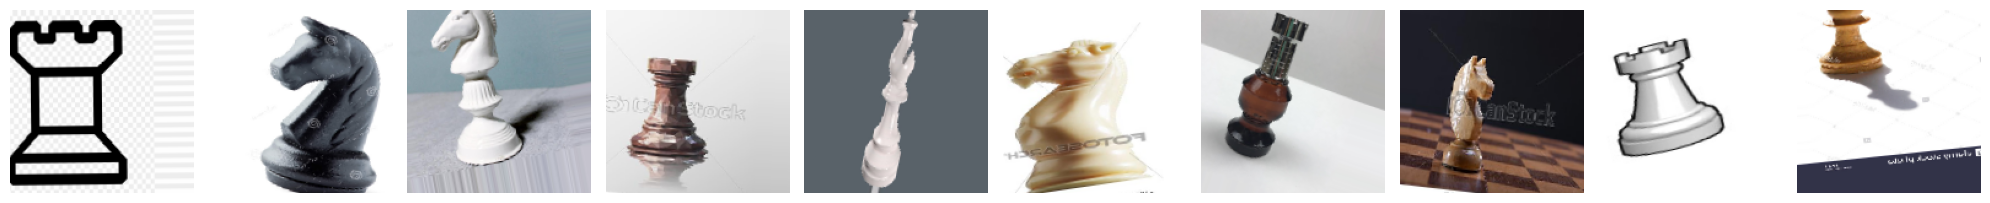

In [4]:
# Visualize some training images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data)
plot_images(sample_training_images[:10])

In [6]:
from tensorflow.keras.applications import VGG16

def build_transfer_learning_model():
    base_model = VGG16(include_top=False, input_shape=(150, 150, 3), weights=None)
    base_model.load_weights('/Users/mac/Pictures/Developer/chessman_classification/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')  # Path to the downloaded weights
    
    # Unfreeze the top layers of the base model
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(6, activation='softmax')  # Assuming 6 classes for chess pieces
    ])

    optimizer = Adam(learning_rate=0.00001)  # learning rate for stability
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_transfer_learning_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.1617 - loss: 2.8104 - val_accuracy: 0.1743 - val_loss: 1.9756
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.2223 - loss: 2.3608 - val_accuracy: 0.1743 - val_loss: 1.9506
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.3252 - loss: 1.8739 - val_accuracy: 0.2477 - val_loss: 1.7617
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.4175 - loss: 1.6619 - val_accuracy: 0.2936 - val_loss: 1.6257
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.4081 - loss: 1.6036 - val_accuracy: 0.4312 - val_loss: 1.4596
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.4218 - loss: 1.5842 - val_accuracy: 0.4862 - val_loss: 1.3118
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.4955 - loss: 1.3912 - val_accuracy: 0.5780 - val_loss: 1.1122
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.5389 - loss: 1.2887 - val_accuracy: 0.6239 - val_loss: 1.0190


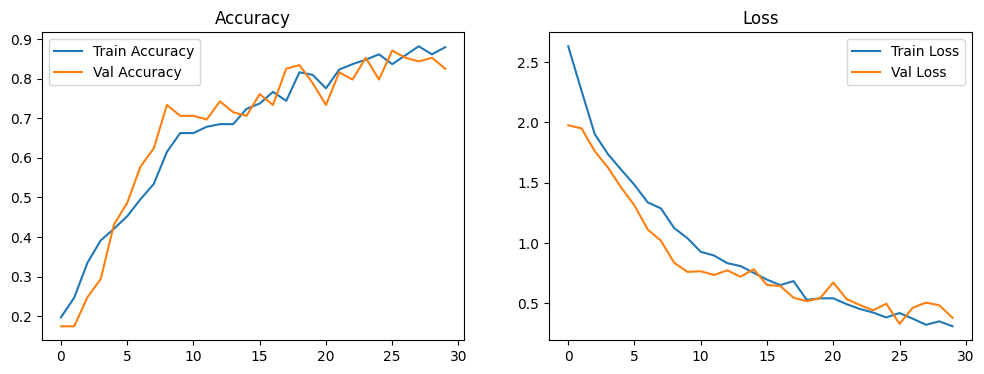

In [31]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

 Model Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 767ms/step
              precision    recall  f1-score   support

           0       0.28      0.29      0.29        17
           1       0.10      0.07      0.08        15
           2       0.18      0.19      0.19        21
           3       0.29      0.29      0.29        21
           4       0.20      0.27      0.23        15
           5       0.11      0.10      0.11        20

    accuracy                           0.20       109
   macro avg       0.19      0.20      0.20       109
weighted avg       0.20      0.20      0.20       109



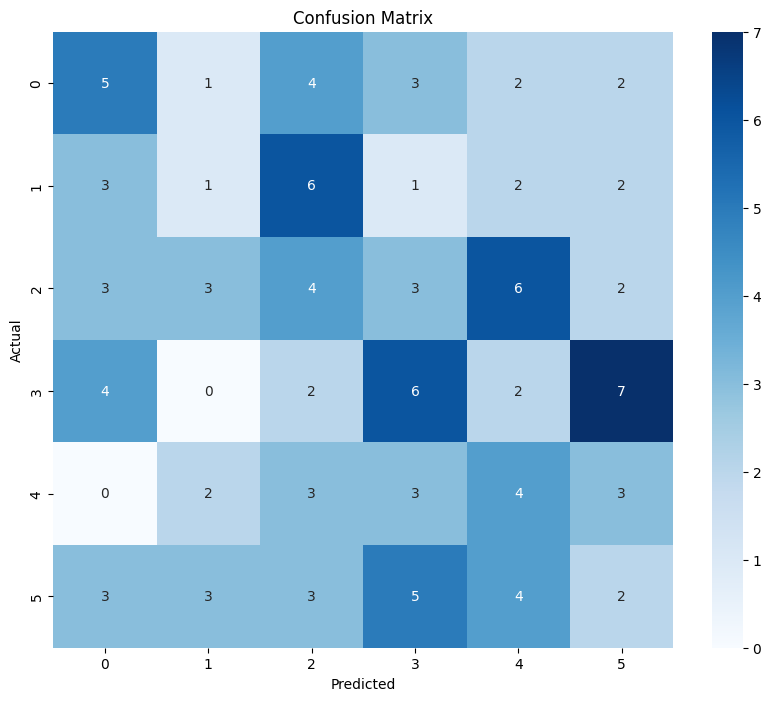

Model training and evaluation completed successfully!


In [33]:

model = tf.keras.models.load_model('best_model.keras')

val_labels = val_data.classes
val_preds = model.predict(val_data)
val_preds_classes = np.argmax(val_preds, axis=1)

print(classification_report(val_labels, val_preds_classes))

conf_matrix = confusion_matrix(val_labels, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model
model.save('chessman_classification_model.keras')

print("Model training and evaluation completed successfully!")